# PCA and PPCA ARD comparison on a simple simulated dataset
___

In [2]:
from advi import * 
from advi_models import * 
import matplotlib.pyplot as plt
import pandas as pd

**Simulated Dataset :**

In [4]:
random_state = 42

In [5]:
torch.manual_seed(random_state)

d1 = dist.MultivariateNormal(loc=torch.Tensor([0.0, 4.0]), covariance_matrix=torch.Tensor([[8.0, 0.0],[0.0, 0.5]]))
d2 = dist.MultivariateNormal(loc=torch.Tensor([-7.0, -2.0]), covariance_matrix=torch.Tensor([[4.0, -1.5],[-1.5, 1.0]]))
d3 = dist.MultivariateNormal(loc=torch.Tensor([7.0, -2.0]), covariance_matrix=torch.Tensor([[4.0, 0.3],[0.3, 1.0]]))
z1 = d1.sample(torch.Size([1000]))
z2 = d2.sample(torch.Size([1000]))
z3 = d3.sample(torch.Size([1000]))
X = torch.cat([z1, z2, z3], dim=0)

X100 = X @ torch.randn(2, 100) + 2.0*torch.randn(3000, 100) # projection on 100 dimensional space with noise 

In [6]:
clrs = np.zeros( (3000))
clrs[1000:2000] = 1
clrs[2000:] = 2

In [7]:
df100 = pd.DataFrame(X100, columns=[f'x{i}' for i in range(100)])
df100['target'] = clrs.astype(np.int32)
df100

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,target
0,3.216754,-2.498561,10.618211,1.254351,-4.738520,0.351858,3.540026,-3.489517,3.427018,-4.518074,...,5.327700,10.253223,15.500156,4.445906,7.275994,0.271595,-7.017539,-6.014864,-0.445487,0
1,2.024248,-1.118304,3.425162,-2.819734,-5.575024,4.622077,1.864912,-1.750134,4.104751,-3.314314,...,5.926879,2.646806,6.248166,0.309664,3.897040,4.723574,-3.956086,-4.552545,0.784336,0
2,2.521313,-0.724241,7.895079,-0.205300,-3.302979,1.584122,2.145923,-0.593768,2.304684,-6.159270,...,3.689055,4.383433,8.764843,1.680488,6.306910,1.950490,3.194798,-1.165034,5.050946,0
3,4.218184,-4.094312,6.367798,-3.937874,-3.500236,-2.290493,-5.670274,-1.685020,1.109478,-4.542211,...,4.506831,8.765724,4.592828,2.167253,2.231727,2.160496,-0.862401,0.649691,-0.052292,0
4,2.982517,-0.865416,8.103500,6.581737,-10.211937,4.463635,-9.085872,-0.686971,4.705244,-2.496448,...,4.166794,8.102274,5.203815,5.182928,4.690309,3.403950,11.557200,-0.071939,-0.223001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-7.515714,1.776459,4.573174,-4.767130,7.612083,-1.141310,22.360214,-4.595749,0.243025,-9.227861,...,-3.766498,-2.053751,5.283466,-11.929273,-1.625913,-1.958641,-23.322449,-13.230386,-0.511109,2
2996,-6.015093,3.578874,3.445682,-1.348584,5.958088,-1.858414,16.063599,-8.485456,0.356002,-8.975222,...,-0.794680,1.870741,11.115371,-6.365886,0.006227,-1.489999,-23.138186,-9.231253,-0.272653,2
2997,-4.720474,7.254530,3.879599,-6.436375,5.094801,0.867065,19.885794,-6.580669,3.213134,-12.992245,...,1.822498,-0.988435,5.093160,-11.712842,-3.525394,-5.842245,-24.692343,-13.217113,-1.521172,2
2998,-6.638158,0.919359,2.662543,-3.694804,7.861497,-1.759213,22.406845,-7.818732,0.685460,-10.334555,...,-1.542088,-0.901580,7.315633,-8.415424,0.636585,-2.307624,-29.208847,-15.130522,-0.037140,2


In [8]:
df100.to_csv('Data/3000pts.csv', index=False)

**Original data in 2 dimensions space:**

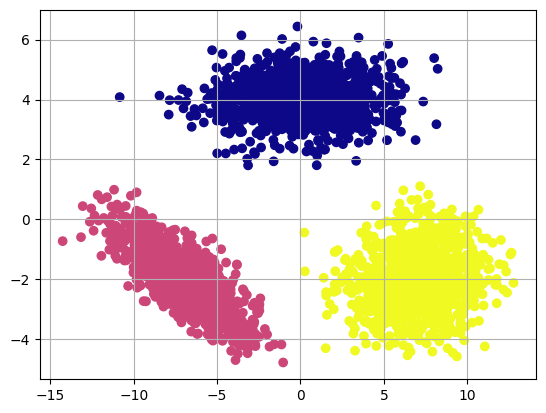

In [9]:
plt.scatter(X[:,0], X[:,1], marker='o', c=clrs, cmap='plasma')
plt.grid()

___
## Sklearn PCA

In [149]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_pred = pca.fit_transform(X100)

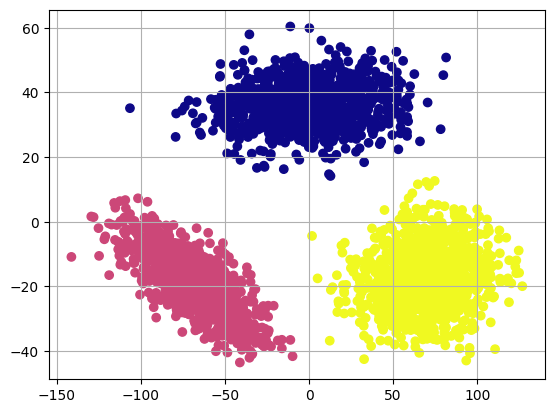

In [150]:
plt.scatter(pca_pred[:,0], pca_pred[:,1], marker='o', c=clrs, cmap='plasma')
plt.grid()

___
## PPCA ARD with automatic differentation variational inference (ADVI)

**2 latent dimension reduction :**

In [151]:
ppca_ard1 = PPCA_ARD(X100, 2, mc_size=5, max_iter=500)
ppca_ard2 = PPCA_ARD(X100, 2, mc_size=10, max_iter=500)
ppca_ard3 = PPCA_ARD(X100, 2, mc_size=30, max_iter=500)

ppca_ard1.fit(X100)
ppca_ard2.fit(X100)
ppca_ard3.fit(X100)

c:\Users\User\Documents\Projets\VariationalInference\advi.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
100%|██████████| 500/500 [01:30<00:00,  5.55it/s]


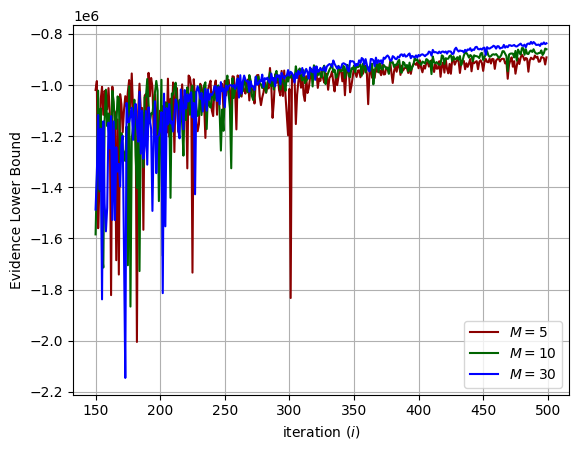

In [185]:
plt.plot(range(150, 500), ppca_ard1.elbo_history()[150:], color='darkred', label='$M=5$')
plt.plot(range(150, 500), ppca_ard2.elbo_history()[150:], color='darkgreen', label='$M=10$')
plt.plot(range(150, 500), ppca_ard3.elbo_history()[150:], color='blue', label='$M=30$')

plt.grid()
plt.legend()
plt.ylabel('Evidence Lower Bound')
plt.xlabel('iteration $(i)$')
plt.savefig('figs/evidence_lower_bound.png')

In [183]:
w, z, sigma, alpha = ppca_ard3.theta_estimates(n_estimators=500)

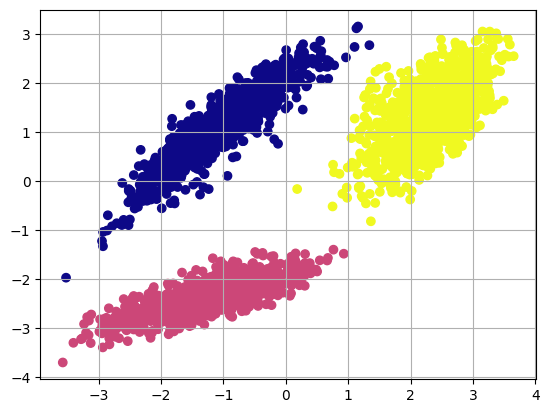

In [184]:
plt.scatter(z[:,0], z[:,1], marker='o', c=clrs, cmap='plasma')
plt.grid()

**30 latent dimensions reduction :**

In [15]:
ppca_ard = PPCA_ARD(X100, 30, mc_size=10, max_iter=1000)
ppca_ard.fit(X100)

c:\Users\User\Documents\Projets\VariationalInference\advi.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
100%|██████████| 1000/1000 [01:28<00:00, 11.34it/s]


In [16]:
w, z, sigma, alpha = ppca_ard.theta_estimates(n_estimators=500)

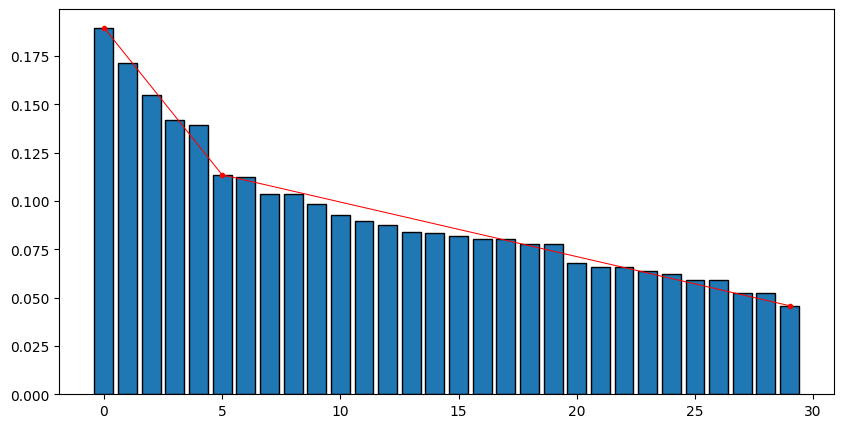

In [25]:
dim_selection = 5

sorted_alpha, sorted_idxs = torch.sort(alpha.squeeze(), descending=True)
idxs = range(len(sorted_alpha))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(idxs,sorted_alpha, edgecolor='black')
sub_pts = [0, dim_selection, 29]
ax.plot(sub_pts, [sorted_alpha[i] for i in sub_pts],  marker='.', color='red', linewidth=0.75)

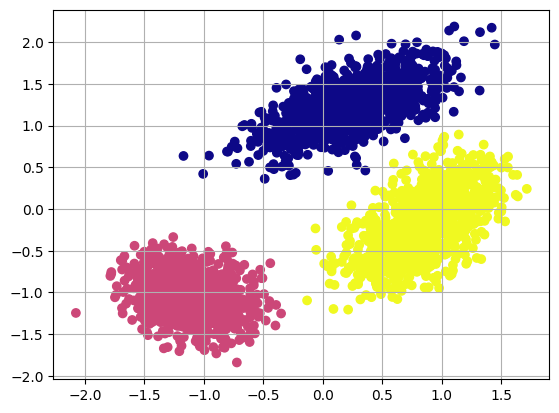

In [24]:
plt.scatter(z[:,0], z[:,1], marker='o', c=clrs, cmap='plasma')
plt.grid()